In [168]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [169]:
num_cities = 5

In [170]:
rng = np.random.default_rng(42)
population = rng.lognormal(mean=11.5, sigma=1.5, size=num_cities).astype(int)
print(population)
total_population = population.sum()
print(f"{total_population=}")

[155916  20744 304271 404678   5289]
total_population=np.int64(890898)


In [171]:
per_person_demand = rng.lognormal(mean=0.25, sigma=0.4, size=num_cities)
per_person_demand

array([0.76271427, 1.35139334, 1.13145336, 1.2754251 , 0.91281909])

In [172]:
demand = population * per_person_demand
total_demand = demand.sum()
print(f"{total_demand=:.2f}")

total_demand=1012185.49


In [173]:
elasticity = rng.normal(-0.5, 0.3, size=100)
elasticity = elasticity[(-3 < elasticity) & (elasticity < 0)][:num_cities]
elasticity

array([-0.23618061, -0.26666242, -0.48019079, -0.16182764, -0.3597472 ])

In [174]:
A = per_person_demand * np.exp(-elasticity)
A

array([0.96590365, 1.76437864, 1.8288617 , 1.4994632 , 1.30803973])

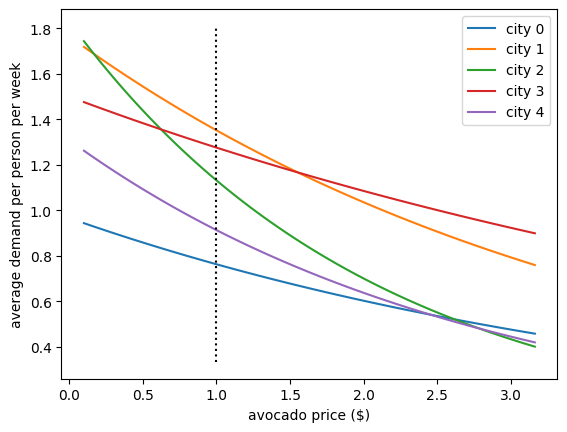

In [175]:
p = np.logspace(-1, 0.5, 100)
qs = [A[i] * np.exp(elasticity[i] * p) for i in range(num_cities)]
for i in range(num_cities):
    plt.plot(p, qs[i], label=f"city {i}")
plt.vlines(1, *plt.ylim(), colors="k", linestyles=":")
plt.legend()
plt.xlabel("avocado price ($)")
plt.ylabel("average demand per person per week")
plt.show()

In [176]:
# price = rng.lognormal(0.5, 0.2, size=10000)
# price = price[(0.8 < price) & (price < 4)]
# plt.hist(price)

In [177]:
average_cost = 1.0
average_price = 1.5 * average_cost

average_price_demand = np.sum(A * np.exp(elasticity * average_price) * population)
average_supply = 1.1 * np.round(average_price_demand / 1e5) * 1e5
average_supply

np.float64(990000.0)

In [178]:
num_weeks = 52

supply = rng.normal(average_supply, 0.2 * average_supply, size=num_weeks).round()
supply

array([1076016., 1037072.,  872358.,  703681., 1004282.,  885160.,
       1036070.,  994327., 1307152.,  942608.,  787347., 1025497.,
       1033559., 1259119., 1155352., 1060660., 1279734.,  754625.,
        863329.,  806538.,  912818.,  717416., 1115760.,  946000.,
        698780.,  788915., 1052076., 1155949., 1385353., 1566945.,
       1072053.,  794071.,  567855., 1043007.,  829038.,  907759.,
        868805.,  962123., 1201064., 1021096.,  958590.,  784941.,
        658413.,  893711.,  979351., 1340050., 1015794., 1184582.,
        891139.,  755381.,  798907.,  846405.])

In [179]:
price = (
    average_price + 0.2 * (average_supply - supply) / (0.2 * average_supply)
).round(2)
price

array([1.41, 1.45, 1.62, 1.79, 1.49, 1.61, 1.45, 1.5 , 1.18, 1.55, 1.7 ,
       1.46, 1.46, 1.23, 1.33, 1.43, 1.21, 1.74, 1.63, 1.69, 1.58, 1.78,
       1.37, 1.54, 1.79, 1.7 , 1.44, 1.33, 1.1 , 0.92, 1.42, 1.7 , 1.93,
       1.45, 1.66, 1.58, 1.62, 1.53, 1.29, 1.47, 1.53, 1.71, 1.83, 1.6 ,
       1.51, 1.15, 1.47, 1.3 , 1.6 , 1.74, 1.69, 1.65])

In [180]:
cost = (average_cost + 0.2 * (average_supply - supply) / (0.2 * average_supply)).round(
    2
)
cost

array([0.91, 0.95, 1.12, 1.29, 0.99, 1.11, 0.95, 1.  , 0.68, 1.05, 1.2 ,
       0.96, 0.96, 0.73, 0.83, 0.93, 0.71, 1.24, 1.13, 1.19, 1.08, 1.28,
       0.87, 1.04, 1.29, 1.2 , 0.94, 0.83, 0.6 , 0.42, 0.92, 1.2 , 1.43,
       0.95, 1.16, 1.08, 1.12, 1.03, 0.79, 0.97, 1.03, 1.21, 1.33, 1.1 ,
       1.01, 0.65, 0.97, 0.8 , 1.1 , 1.24, 1.19, 1.15])

In [181]:
data = {"week": [], "city": [], "supply": [], "cost": [], "price": []}
for w in range(num_weeks):
    for c in range(num_cities):
        data["week"].append(w)
        data["city"].append(c)
        data["supply"].append(np.round(supply[w] * population[c] / total_population))
        data["cost"].append(cost[w])
        data["price"].append(price[w])

df = pd.DataFrame(data)
df["supply"] = df["supply"].astype(int)

city_df = pd.DataFrame({"A": A, "elasticity": elasticity, "population": population})
df = df.merge(city_df, how="left", left_on="city", right_index=True)

assert np.allclose(supply, df.groupby("week").sum()["supply"])
assert np.allclose(df.groupby("week").mean()["price"], price)

df["price"] = (df["price"] * (1 + 0.05 * rng.normal(size=len(df)))).round(2)

df["demand"] = (
    (df["population"] * df["A"] * np.exp(df["elasticity"] * df["price"]))
    * (1 + 0.05 * rng.normal(size=len(df)))
).astype(int)

df["sold"] = np.minimum(df["supply"], df["demand"])
df["sold_out"] = df["supply"] == df["sold"]
df["waste"] = df["supply"] - df["sold"]

df

,week,city,supply,cost,price,A,elasticity,population,demand,sold,sold_out,waste
0,0,0,188313,0.91,1.56,0.965904,-0.236181,155916,101090,101090,False,87223
1,0,1,25054,0.91,1.35,1.764379,-0.266662,20744,23644,23644,False,1410
2,0,2,367495,0.91,1.47,1.828862,-0.480191,304271,262515,262515,False,104980
3,0,3,488765,0.91,1.35,1.499463,-0.161828,404678,478984,478984,False,9781
4,0,4,6388,0.91,1.48,1.308040,-0.359747,5289,4225,4225,False,2163
...,...,...,...,...,...,...,...,...,...,...,...,...
255,51,0,148129,1.15,1.76,0.965904,-0.236181,155916,101467,101467,False,46662
256,51,1,19708,1.15,1.64,1.764379,-0.266662,20744,24093,19708,True,0
257,51,2,289075,1.15,1.76,1.828862,-0.480191,304271,237008,237008,False,52067
258,51,3,384468,1.15,1.66,1.499463,-0.161828,404678,482794,384468,True,0


In [182]:
df["sold_out"].sum()

np.int64(76)

(array([96., 15., 20., 30., 24., 33., 18., 13.,  7.,  4.]),
 array([0.        , 0.05785269, 0.11570537, 0.17355806, 0.23141074,
        0.28926343, 0.34711612, 0.4049688 , 0.46282149, 0.52067418,
        0.57852686]),
 <BarContainer object of 10 artists>)

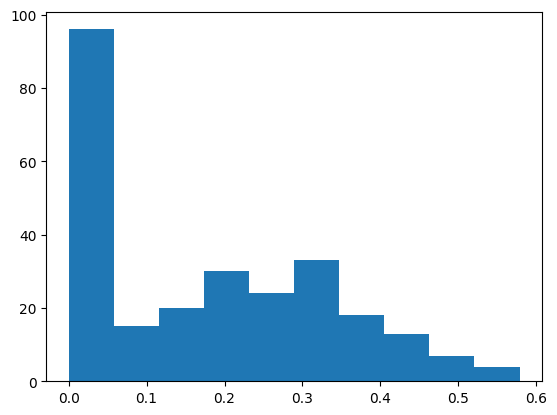

In [183]:
plt.hist((df["waste"] / df["supply"]))

In [184]:
df[["city", "supply", "price", "sold"]]

,city,supply,price,sold
0,0,188313,1.56,101090
1,1,25054,1.35,23644
2,2,367495,1.47,262515
3,3,488765,1.35,478984
4,4,6388,1.48,4225
...,...,...,...,...
255,0,148129,1.76,101467
256,1,19708,1.64,19708
257,2,289075,1.76,237008
258,3,384468,1.66,384468


<Axes: xlabel='price', ylabel='sold_per_person'>

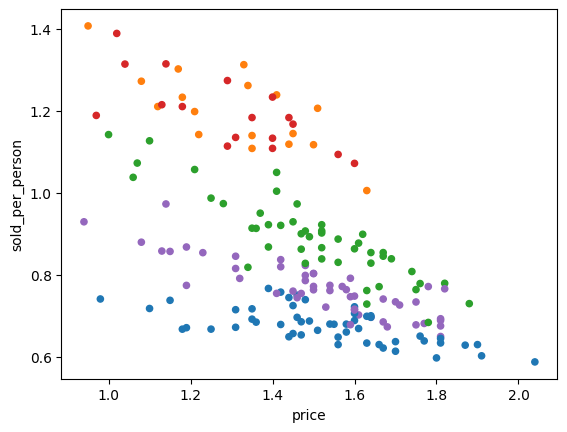

In [185]:
df["sold_per_person"] = df["sold"] / df["population"]
s = pd.Series(["C0", "C1", "C2", "C3", "C4"])
df[~df["sold_out"]].plot.scatter(
    "price",
    "sold_per_person",
    c=df.loc[~df["sold_out"], "city"].apply(lambda c: f"C{c}"),  # type: ignore
)

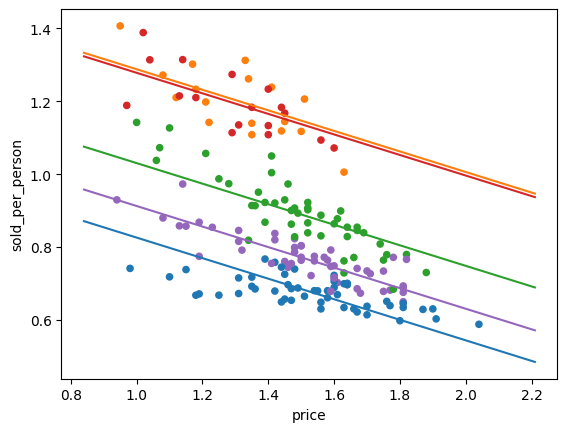

In [186]:
from sklearn.linear_model import LinearRegression

mask = ~df["sold_out"]
X = pd.concat(
    [pd.get_dummies(df.loc[mask, "city"], prefix="city"), df.loc[mask, "price"]], axis=1
)
y = df.loc[mask, "sold_per_person"]

model = LinearRegression(fit_intercept=False)
model.fit(X, y)

min_price = df["price"].min()
max_price = df["price"].max()

df[~df["sold_out"]].plot.scatter(
    "price",
    "sold_per_person",
    c=df.loc[~df["sold_out"], "city"].apply(lambda c: f"C{c}"),  # type: ignore
)

for c in range(num_cities):
    XX = X[:0].copy()
    XX.loc[:] = np.zeros((2, 6))
    XX[f"city_{c}"] = 1
    XX["price"] = [min_price - 0.1, max_price + 0.1]
    yy = model.predict(XX)
    plt.plot(XX["price"], yy, f"C{c}")

In [188]:
temp = df[["city", "price", "sold_per_person"]].copy()
temp["demand"] = temp["sold_per_person"]
temp.drop(columns=["sold_per_person"], inplace=True)
temp.to_csv("avocados.csv", index=False)

In [189]:
model.coef_

array([ 1.10801487,  1.57024692,  1.31254316,  1.56051977,  1.19475731,
       -0.28212941])

ValueError: Length of values (100) does not match length of index (2)

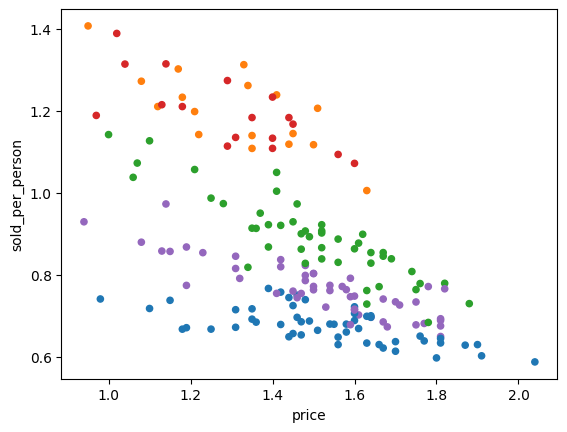

In [193]:
mask = ~df["sold_out"]
X = pd.concat(
    [
        pd.get_dummies(df.loc[mask, "city"], prefix="city"),
        pd.get_dummies(df.loc[mask, "city"], prefix="price_city"),
    ],
    axis=1,
)
for c in range(num_cities):
    X[f"price_city_{c}"] *= df.loc[mask, "price"]

y = df.loc[mask, "sold_per_person"]

model = LinearRegression(fit_intercept=False)
model.fit(X, y)

min_price = df["price"].min()
max_price = df["price"].max()

df[~df["sold_out"]].plot.scatter(
    "price",
    "sold_per_person",
    c=df.loc[~df["sold_out"], "city"].apply(lambda c: f"C{c}"),  # type: ignore
)


for c in range(num_cities):
    XX = X[:0].copy()
    XX.loc[:] = np.zeros((2, 10))
    XX[f"city_{c}"] = 1
    XX[f"price_city_{c}"] = p
    yy = model.predict(XX)
    plt.plot(XX[f"price_city_{c}"], yy, f"C{c}")

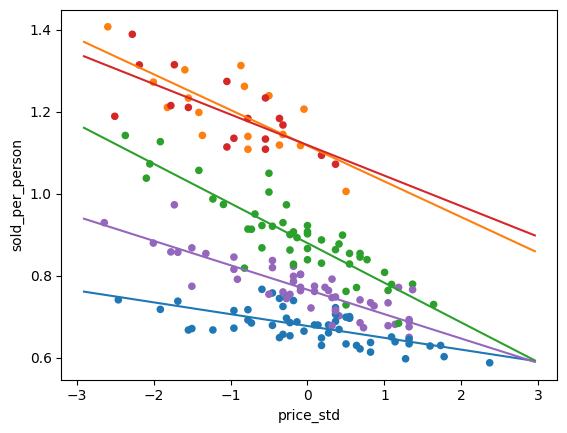

In [196]:
from sklearn.linear_model import Ridge

df["price_std"] = (df["price"] - df["price"].mean()) / df["price"].std()


mask = ~df["sold_out"]
X = pd.concat(
    [
        pd.get_dummies(df.loc[mask, "city"], prefix="city"),
        pd.get_dummies(df.loc[mask, "city"], prefix="price_std_city"),
    ],
    axis=1,
)
for c in range(num_cities):
    X[f"price_std_city_{c}"] *= df.loc[mask, "price_std"]

y = df.loc[mask, "sold_per_person"]

model = Ridge(fit_intercept=False, alpha=0.0)
model.fit(X, y)

df[~df["sold_out"]].plot.scatter(
    "price_std",
    "sold_per_person",
    c=df.loc[~df["sold_out"], "city"].apply(lambda c: f"C{c}"),  # type: ignore
)

p = np.linspace(df["price_std"].min() * 1.1, df["price_std"].max() * 1.1, 100)
pp = p * df["price"].std() + df["price"].mean()

for c in range(num_cities):
    XX = X[:0].copy()
    XX.loc[:] = np.zeros((2, 10))
    XX[f"city_{c}"] = 1
    XX[f"price_std_city_{c}"] = [p[0], p[-1]]
    yy = model.predict(XX)
    plt.plot(XX[f"price_std_city_{c}"], yy, f"C{c}")
    # plt.plot(p, A[c] * np.exp(elasticity[c] * pp), f"--C{c}", label=f"city {i}")

In [ ]:
import gurobipy as gp
import gurobipy_pandas as gppd
import gurobi_ml as gpml

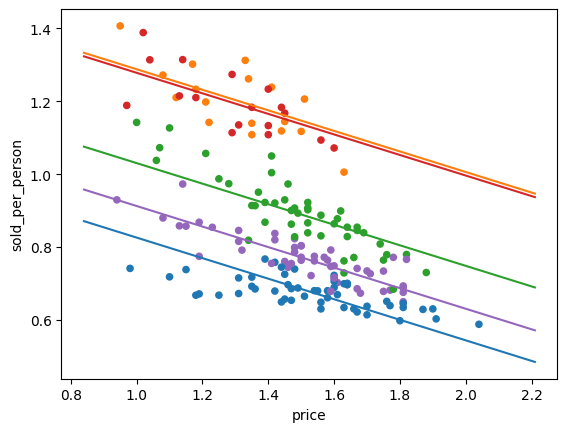

In [ ]:
from sklearn.linear_model import LinearRegression

mask = ~df["sold_out"]
X = pd.concat(
    [pd.get_dummies(df.loc[mask, "city"], prefix="city"), df.loc[mask, "price"]], axis=1
)
y = df.loc[mask, "sold_per_person"]

demand_model = LinearRegression(fit_intercept=False)
demand_model.fit(X, y)

min_price = df["price"].min()
max_price = df["price"].max()

df[~df["sold_out"]].plot.scatter(
    "price",
    "sold_per_person",
    c=df.loc[~df["sold_out"], "city"].apply(lambda c: f"C{c}"),  # type: ignore
)

for c in range(num_cities):
    XX = X[:0].copy()
    XX.loc[:] = np.zeros((2, 6))
    XX[f"city_{c}"] = 1
    XX["price"] = [min_price - 0.1, max_price + 0.1]
    yy = demand_model.predict(XX)
    plt.plot(XX["price"], yy, f"C{c}")

In [ ]:
df["max_supply"] = df["week"].apply(lambda w: supply[w])
df

,week,city,supply,cost,price,A,elasticity,population,demand,sold,sold_out,waste,sold_per_person,max_supply
0,0,0,188313,0.91,1.56,0.965904,-0.236181,155916,101090,101090,False,87223,0.648362,1076016.0
1,0,1,25054,0.91,1.35,1.764379,-0.266662,20744,23644,23644,False,1410,1.139799,1076016.0
2,0,2,367495,0.91,1.47,1.828862,-0.480191,304271,262515,262515,False,104980,0.862767,1076016.0
3,0,3,488765,0.91,1.35,1.499463,-0.161828,404678,478984,478984,False,9781,1.183618,1076016.0
4,0,4,6388,0.91,1.48,1.308040,-0.359747,5289,4225,4225,False,2163,0.798828,1076016.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,51,0,148129,1.15,1.76,0.965904,-0.236181,155916,101467,101467,False,46662,0.650780,846405.0
256,51,1,19708,1.15,1.64,1.764379,-0.266662,20744,24093,19708,True,0,0.950058,846405.0
257,51,2,289075,1.15,1.76,1.828862,-0.480191,304271,237008,237008,False,52067,0.778937,846405.0
258,51,3,384468,1.15,1.66,1.499463,-0.161828,404678,482794,384468,True,0,0.950059,846405.0


In [ ]:
import gurobipy as gp
import gurobipy_pandas as gppd
from gurobi_ml import add_predictor_constr

add_predictor_constr

<function gurobi_ml.add_predictor.add_predictor_constr(gp_model, predictor, input_vars, output_vars=None, **kwargs)>

In [ ]:
opt_model = gp.Model(name="admissions")
opt_model.setAttr("ModelSense", gp.GRB.MAXIMIZE)


# decision variables
X = (
    df[["week", "city", "max_supply", "population"]]
    .gppd.add_vars(opt_model, name="price")
    .gppd.add_vars(opt_model, name="supply", ub="max_supply")
    .gppd.add_vars(opt_model, name="demand")
    .gppd.add_vars(opt_model, name="sales")
)

# supply constraint
cs = gppd.add_constrs(
    opt_model,
    X.groupby("week")["supply"].sum(),
    gp.GRB.LESS_EQUAL,
    X.groupby("week")["max_supply"].first(),
)

supply_constrs = []
for w in range(num_weeks):
    c = X.loc[5 * w : 5 * (w + 1), "supply"].sum() <= X.loc[5 * w, "max_supply"]
    opt_model.addConstr(c)
    supply_constrs.append(c)

# demand
input_vars = pd.concat([pd.get_dummies(X["city"], prefix="city"), X["price"]], axis=1)  # type: ignore
demand_constr = add_predictor_constr(
    opt_model, demand_model, input_vars=input_vars, output_vars=X["demand"]
)

# sales
gppd.add_constrs(opt_model, X["sales"], gp.GRB.LESS_EQUAL, X["supply"])
gppd.add_constrs(
    opt_model, X["sales"], gp.GRB.LESS_EQUAL, X["demand"] * X["population"]
)

# objective
revenue = (X["price"] * X["sales"]).sum()
opt_model.setObjective(revenue)

opt_model.optimize()
print(opt_model.ObjVal)

Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 884 rows, 2340 columns and 3431 nonzeros
Model fingerprint: 0x0e04cc48
Model has 260 quadratic objective terms
Coefficient statistics:
  Matrix range     [3e-01, 4e+05]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 2e+00]
  Bounds range     [1e+00, 2e+06]
  RHS range        [6e+05, 2e+06]
Presolve removed 528 rows and 1820 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 532 rows and 1828 columns
Presolve time: 0.15s
Presolved: 865 rows, 770 columns, 2323 nonzeros
Presolved model has 256 bilinear constraint(s)
Variable types: 770 continuous, 0 integer (0 binary)

Root relaxation: objective 1.599659e+08, 828 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj 

In [ ]:
cs[0].

<gurobi.Constr R0>

In [ ]:
X.loc[:4, "supply"]

0     <gurobi.Var supply[0] (value 86378.62294446785)>
1    <gurobi.Var supply[1] (value 16286.601023867785)>
2     <gurobi.Var supply[2] (value 199684.4103123924)>
3    <gurobi.Var supply[3] (value 315754.00972295273)>
4     <gurobi.Var supply[4] (value 3159.535718142993)>
Name: supply, dtype: object

In [ ]:
X.groupby("week")["supply"].sum().gppd.x

AttributeError: 'gurobipy._core.LinExpr' object has no attribute 'getAttr'

In [ ]:
X.groupby("week")["max_supply"].first(),

(week
 0     1076016.0
 1     1037072.0
 2      872358.0
 3      703681.0
 4     1004282.0
 5      885160.0
 6     1036070.0
 7      994327.0
 8     1307152.0
 9      942608.0
 10     787347.0
 11    1025497.0
 12    1033559.0
 13    1259119.0
 14    1155352.0
 15    1060660.0
 16    1279734.0
 17     754625.0
 18     863329.0
 19     806538.0
 20     912818.0
 21     717416.0
 22    1115760.0
 23     946000.0
 24     698780.0
 25     788915.0
 26    1052076.0
 27    1155949.0
 28    1385353.0
 29    1566945.0
 30    1072053.0
 31     794071.0
 32     567855.0
 33    1043007.0
 34     829038.0
 35     907759.0
 36     868805.0
 37     962123.0
 38    1201064.0
 39    1021096.0
 40     958590.0
 41     784941.0
 42     658413.0
 43     893711.0
 44     979351.0
 45    1340050.0
 46    1015794.0
 47    1184582.0
 48     891139.0
 49     755381.0
 50     798907.0
 51     846405.0
 Name: max_supply, dtype: float64,)